#IMPORTING MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from dipy.core.gradients import gradient_table
from dipy.data import get_sphere, HemiSphere
from dipy.io import read_bvals_bvecs
from dipy.io.streamline import save_trk
from dipy.direction import (peaks_from_model, ProbabilisticDirectionGetter)
from dipy.reconst.gqi import GeneralizedQSamplingModel
from dipy.reconst.peaks import reshape_peaks_for_visualization
from dipy.tracking import utils
from dipy.tracking.local import (ThresholdTissueClassifier, LocalTracking,ActTissueClassifier)
from dipy.tracking.streamline import Streamlines
from dipy.tracking.utils import random_seeds_from_mask
from dipy.viz import window, actor, fvtk
from dipy.viz.colormap import line_colors
from dipy.io.image import save_nifti

LOADING DATA: DWI, BVEC, BVAL, MASK

In [ ]:
shm.cart2

In [5]:
fimg = ("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/data.nii.gz")
img = nib.load(fimg)
data = img.get_data()

fbval=("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/bval.txt")
fbvec = ("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/bvec.txt")
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals,bvecs)
print(gtab.bvals)

print('data.shape (%d, %d, %d, %d)' % data.shape)
affine = img.affine
#Read the voxel size from the image header.
voxel_size = img.header.get_zooms()[:3]
#To import fod?
#sh_data = nib.load(args.sh_file).get_data().astype('float64')

#importing mask
mask=("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/mask.nii.gz")
img = nib.load(mask)
mask = img.get_data()
print('mask.shape (%d, %d, %d)' % mask.shape)

[    0.     0.     0.     0.     0.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
data.shape (140, 140, 96, 69)
mask.shape (140, 140, 96)


In [8]:
S0s = data[:, :, :, gtab.b0s_mask]
nib.save(nib.Nifti1Image(S0s, img.affine), 'b0.nii.gz')


VISUALIZE 2D RESULTS IN MATPLOTLIB

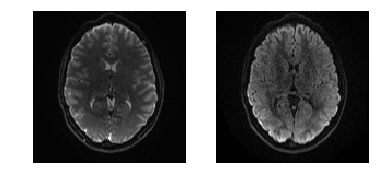

<Figure size 432x288 with 0 Axes>

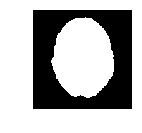

In [23]:
#For example, let’s show here the middle axial slices of DWI, b0, and binary mask

axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

#showing mask
axial_middle = data.shape[2] // 2
plt.figure('Showing the mask')
plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(mask[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.show()

#GENERALIZED QBALL MODEL (GQI)

In [7]:
#Instantiate the model and apply it to the data.
#gqmodel = GeneralizedQSamplingModel(gtab, sampling_length=3)

#Lets just use one slice only from the data.
# dataslice = data[:, :, data.shape[2] // 2]
# mask_slice = dataslice[..., 0] > 50
# gqfit = gqmodel.fit(dataslice, mask=mask_slice)

#Load an ODF reconstruction sphere
#The sphere is an object that represents the spherical discrete grid where the ODF values will be evaluated.

sphere = get_sphere('symmetric724')
#Calculate the ODFs with this specific sphere
# ODF = gqfit.odf(sphere)
# print('ODF.shape (%d, %d, %d)' % ODF.shape)

# #and now on the whole dataset
gqmodel = GeneralizedQSamplingModel(gtab, sampling_length=1.6)  #sampling length is lambda
#gqfit = gqmodel.fit(data, mask)
# gq_odf = gqfit.odf(sphere)
# # print('odf.shape (%d, %d, %d, %d)' % ODF.shape)

In [55]:
odf_1000_standard.shape

(140, 140, 724)

In [16]:
#In DIPY we can also use the peaks_from model function to fit any model to the data.

#The relative peak threshold parameter specifies that only peaks greater than relative peak threshold*m shoudl be returned
#where m is the value of the largest peak. Min separation angle sets the threshold for the minimmum angular distance in 
#degrees between two peaks. If the peaks are closer than this threshold only the larger of the two is returned. These two
#metrics help to get robust directions with noisy ODF. Peaks_from_model returns a PeaksAndMetrics object which holds all
#the different outputs. 
#If the parameter return_sh is true the ODFs will be represented by their SH expansion
#If the parameter ODF is true, the ODF will be returned in the PAM output object. 

# gqi_peaks_1000= peaks_from_model(model=gqmodel,
#                            data=data,
#                            sphere=sphere,
#                            relative_peak_threshold=.5,        
#                            min_separation_angle=25,
#                            mask=mask, return_odf=True,
#                            normalize_peaks=True)

# gqpeak_values = gqi_peaks.peak_values    #value of odf at a maximum point. odf[peak_indices[i]]==peak_values[i]
# gqpeak_indices = gqi_peaks.peak_indices  #show which sphere points have the maximum values

#Compute GFA
GFA = gqi_peaks_1000.gfa
# print('GFA.shape (%d, %d, %d)' % GFA.shape)
# save_nifti('/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/gfa_map.nii.gz', GFA, img.affine)

# #save peaks indices and peaks for visualization
# nib.save(nib.Nifti1Image(gqpeaks.peak_indices, img.affine), 'gqi_peaks_indices_l14_standard')
# nib.save(nib.Nifti1Image(reshape_peaks_for_visualization(gqpeaks), img.affine),
#              'gqi_peaks_l14_standard.nii.gz')

#Let s recompute the GQ ODF in sh Mrtrix basis so that we can visualize them in Mrview
# gqpeaks_mrtrix = peaks_from_model(model=gqmodel,
#                            data=data,
#                            sphere=sphere,
#                            relative_peak_threshold=.5,
#                            min_separation_angle=25,
#                            mask=mask, sh_basis_type='mrtrix', 
#                            return_odf=True, return_sh=True,
#                            normalize_peaks=True)
# #save odf
# nib.save(nib.Nifti1Image(gqpeaks_mrtrix.shm_coeff.astype(np.float32),
#                                   img.affine, img.header), '/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/dsi_studio/odf_14_gqi_prova_mrtrix.nii.gz')
# # # #NEED TO RESCALE THEM! LOOK FOR NIBABEL WAY!!!!!!

VISUALIZE PEAKS

In [12]:
#Enables/disables interactive visualization
interactive = True
ren = window.Renderer()
window.clear(ren)
gq_peaks = actor.peak_slicer(gqi_peaks_1000.peak_dirs, gqi_peaks_1000.peak_values, colors=None)
# gq_peaks.display_extent(81, 81, 73, 73, 62, 62)
ren.set_camera(position=(0, 10, 0))
ren.add(gq_peaks)

print('Saving illustration as gqi_peaks.png')
window.record(ren, out_path='/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/3-5-10/gqi_peaks_16_gqi2.png', size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as gqi_peaks.png


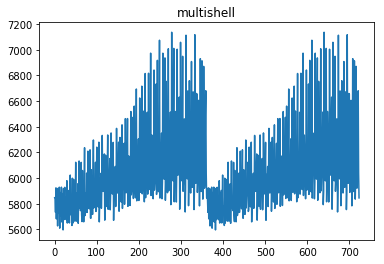

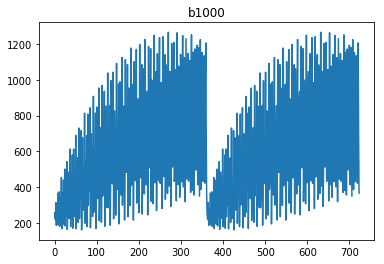

In [44]:
vox_odf_multishell = gqi_peaks.odf[81, 73, 62, :]
vox_odf.shape
plt.plot(vox_odf_multishell)
plt.title('multishell')
plt.show()

vox_odf_1000 = gqi_peaks_1000.odf[81, 73, 62, :]
plt.plot(vox_odf_1000)
plt.title('b1000')
plt.show()

VISUALIZE ODF

In [14]:
#Enables/disables interactive visualization
interactive = True
r = window.Renderer()
# gqiodfs = gqpeaks.odf

gqi_odfs_actor = actor.odf_slicer(gqi_peaks_1000.odf, sphere=sphere, scale=0.4)

# gqi_odfs_actor.display_extent(81, 81, 73, 73, 62, 62)
r.set_camera(position=(0, 10, 0))
#gqi_odfs_actor.display(z=0)
r.add(gqi_odfs_actor)

# print('Saving illustration as gqi_odfs.png')
window.record(r, out_path='~/Desktop/multishell_gqi2.png', size=(600, 600))
if interactive:
    window.show(r)
    

In [17]:
#local tracker assumes that the data is sampled on a regular grid. seeds(same space as the affine!). 
seeds = random_seeds_from_mask(GFA > 0.4, seeds_count=1)

#Define a tissue classifier. Streamlines will stop propagating for GFA < .25
tissue_classifier = ThresholdTissueClassifier(GFA, .25)


DETERMINISTIC TRACTOGRAPHY

In [65]:
# Initialization of LocalTracking from the peaks. The computation happens in the next step.
# Maxlen: Maximum number of steps to track from seed. Used to prevent infinite loops. 
# return_all : bool If true, return all generated streamlines, otherwise only streamlines reaching end points 
# or exiting the image.
streamlines_generator = LocalTracking(gqi_peaks, tissue_classifier, seeds, affine=np.eye(4), step_size=0.5)
                                                                                               
#Generate streamline object
streamlines = Streamlines(streamlines_generator)

#Save the trk file
save_trk("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/multishell/from_mgh/deterministic_gqi_23_5.trk",
         streamlines,
         img.affine,
         shape=img.shape[:3], vox_size=img.header.get_zooms()[:3])

In [56]:
print(len(streamlines))

59518


VISUALIZE STREAMLINES

In [38]:
#Prepare display objects
color = line_colors(streamlines)

if window.have_vtk:
    streamlines_actor = actor.line(streamlines, line_colors(streamlines))

    #Create the 3D display.
    r = window.Renderer()
    r.add(streamlines_actor)

    #Save still images for this static example. Or for interactivity use
    window.record(r, n_frames=1, out_path='deterministic.png', size=(800, 800))
    if interactive:
        window.show(r)

PROBABILISTIC TRACKING

In [62]:
# Probabilistic tracking Get directions
# We can either use the sh coefficients or represent the ODF on the discrete sphere (PMF). 

# prob_dg = ProbabilisticDirectionGetter.from_shcoeff(gqi_peaks.odf, max_angle=30., sphere=sphere)


# from dipy.data import small_sphere #instead of the default for memory issues
pmf = gqi_peaks.odf.clip(min=0)
prob_dg = ProbabilisticDirectionGetter.from_pmf(pmf, max_angle=30, sphere=sphere)

streamlines_generator = LocalTracking(prob_dg, tissue_classifier, seeds, affine=np.eye(4), step_size=0.5)
                                                                                               
#Generate streamline object
streamlines = Streamlines(streamlines_generator)

#Save the trk file
save_trk("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/probabilistic_gqi_23_5.trk",
         streamlines,
         img.affine,
         shape=img.shape[:3], vox_size=img.header.get_zooms()[:3])




#Bootstrap

In [20]:
from dipy.direction import BootDirectionGetter
from dipy.data import small_sphere

boot_dg_gq = BootDirectionGetter.from_data(data, gqmodel, max_angle=30.,
                                           sphere=sphere)

boot_streamline_generator = LocalTracking(boot_dg_gq, tissue_classifier, seeds,
                                          affine=np.eye(4), step_size=.5)

streamlines = Streamlines(boot_streamline_generator)

#Save the trk file
save_trk("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/1000/from_mgh/probabilistic_gqi_bootstrap.trk",
         streamlines,
         img.affine,
         shape=img.shape[:3], vox_size=img.header.get_zooms()[:3])

In [35]:
#Define the seeds from a white matter binary mask
#Load the mask
seed_mask=("/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/structural/wm_mask_bin_res.nii.gz")
imgm = nib.load(seed_mask)
seed_mask = imgm.get_data()

seeds = random_seeds_from_mask(seed_mask, seeds_count=1, seed_count_per_voxel=True, affine=img.affine)

ANATOMICALLY CONSTRAINED TRACTOGRAPHY (ACT)


Anatomically-constrained tractography (ACT) [Smith2012] uses information from anatomical images to determine when the 
tractography stops. The include_map defines when the streamline reached a ‘valid’ stopping region (e.g. gray matter
partial volume estimation (PVE) map) and the exclude_map defines when the streamline reached an ‘invalid’ stopping
region (e.g. corticospinal fluid PVE map). 

In [36]:
#Import PVE maps
img_pve_gm = nib.load('/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/structural/T12diff_pve_1_res.nii.gz')
img_pve_csf = nib.load('/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/structural/T12diff_pve_0_res.nii.gz')
img_pve_wm = nib.load('/space/hemera/1/users/cmaffei/scilpy_mrtrix_comparison/structural/T12diff_pve_2_res.nii.gz')

# The background of the anatomical image should be added to the include_map
# to keep streamlines exiting the brain (e.g. through the brain stem). The ACT tissue classifier uses a trilinear 
# interpolation at the tracking position.
background = np.ones(img_pve_gm.shape)
background[(img_pve_gm.get_data() +
            img_pve_wm.get_data() +
            img_pve_csf.get_data()) > 0] = 0
                       
include_map = img_pve_gm.get_data()
include_map[background > 0] = 1
exclude_map = img_pve_csf.get_data()

act_classifier = ActTissueClassifier(include_map, exclude_map)

#Look at the pve maps in matplotlib
fig = plt.figure()
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(include_map[:, :, data.shape[2] // 2].T, cmap='gray', origin='lower',
           interpolation='nearest')
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(exclude_map[:, :, data.shape[2] // 2].T, cmap='gray', origin='lower',
           interpolation='nearest')
fig.tight_layout()
fig.savefig('act_maps.png')

#Track
all_streamlines_act_classifier = LocalTracking(prob_dg,
                                               act_classifier,
                                               seeds, 
                                               img.affine, step_size=0.75,
                                               return_all=True)

#save trk
streamlines = Streamlines(all_streamlines_act_classifier)
save_trk("probabilistic_peaks_from_gqimodel_act_from_sh_pmfthresh.trk", streamlines, img.affine, seed_mask.shape)                

/autofs/space/tinia_001/users/chiara/anaconda2/lib/python2.7/site-packages/dipy/io/trackvis.py:22: DeprecationWarning: The `dipy.io.trackvis.save_trk` function is deprecated as of version 0.14 of Dipy and will be removed in a future version. Please use `dipy.io.streamline.save_trk` function instead
  DeprecationWarning)


VISUALIZE STREAMLINES

In [ ]:
#Prepare display objects
color = line_colors(streamlines)

if window.have_vtk:
    streamlines_actor = actor.line(streamlines, line_colors(streamlines))

    #Create the 3D display.
    r = window.Renderer()
    r.add(streamlines_actor)

    #Save still images for this static example. Or for interactivity use
    window.record(r, n_frames=1, out_path='deterministic.png', size=(800, 800))
    if interactive:
        window.show(r)